# CDS-RL Demos
A place to experiment with RL techniques on various systems that are well-understood by CDS

Note: set up a conda environment according to setup_instructions.txt 

In [ ]:
import matplotlib
%matplotlib notebook

# Setup outputs
output_dir = '/Users/nataliebernat/Documents/Github/Research/Doyle_RLandCtrl/RL_outputs'
fig_dir = output_dir+'/figures/'


## Sanity check: Spinningup

Setup

In [ ]:
from spinup import ppo, vpg
from spinup.utils import plot
import tensorflow as tf
import gym
import matplotlib.pyplot as plt

import matplotlib
%matplotlib notebook

# Setup outputs
output_dir = '/Users/nataliebernat/Documents/Github/Research/Doyle_RLandCtrl/RL_outputs'
fig_dir = output_dir+'/figures/'

In [ ]:
env_fn = lambda : gym.make('LunarLander-v2')
ac_kwargs = dict(hidden_sizes=[64,64], activation=tf.nn.relu)
num_steps_per_epoch=5000
num_epochs = 100 #(this will take like 5-10min per experiment)

Run each exp (saves outputs automatically)

In [ ]:
exp_name = 'vpg_test'
logger_kwargs = dict(output_dir=output_dir+'/spinup_tests/'+exp_name+'/', exp_name=exp_name)
vpg(env_fn=env_fn, steps_per_epoch=num_steps_per_epoch, epochs=num_epochs, logger_kwargs=logger_kwargs)

In [ ]:
exp_name = 'ppo_test'

tf.reset_default_graph()
logger_kwargs = dict(output_dir=output_dir+'/spinup_tests/'+exp_name+'/', exp_name=exp_name)
ppo(env_fn=env_fn, ac_kwargs=ac_kwargs, steps_per_epoch=num_steps_per_epoch, epochs=num_epochs, logger_kwargs=logger_kwargs)

Plot the learning curves (Sometimes this crashes the kernel, but the data is saved to disk so just try this again)

In [ ]:
#plot_data(data, xaxis='Epoch', value="AverageEpRet", condition="Condition1", smooth=1, **kwargs)
data = plot.get_all_datasets([output_dir+'/spinup_tests'], None, None, None)
plt.figure()
plot.plot_data(data)

## Sanity Check: Stable-Baselines

Learn policy for cartpole; learning displays; render videos

In [ ]:
import gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt

from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2

import matplotlib
%matplotlib notebook

# Setup outputs
output_dir = '/Users/nataliebernat/Documents/Github/Research/Doyle_RLandCtrl/RL_outputs'
fig_dir = output_dir+'/figures/'

In [ ]:
env = gym.make('CartPole-v1')
env = DummyVecEnv([lambda: env])  # The algorithms require a vectorized environment to run

model = PPO2(MlpPolicy, env, verbose=1)

In [ ]:
model.learn(total_timesteps=100)

In [ ]:
# NOTE: This is very slow.... Eventually make a wrapper for this, and just generate a video and then play the video

obs = env.reset()
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
for i in range(1000):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    

## YPL experiments

## Modified Cartpole SysID experiments

## CDS Alpha initial experiments

In [ ]:
from spinup import ppo, vpg
from spinup.utils import plot
import tensorflow as tf
import gym
import matplotlib.pyplot as plt

import matplotlib
%matplotlib notebook

# Setup outputs
output_dir = '/Users/nataliebernat/Documents/Github/Research/Doyle_RLandCtrl/RL_outputs'
fig_dir = output_dir+'/figures/'

In [ ]:
import gym_cdsalpha

In [ ]:
env_fn = lambda : gym.make('cdsalpha-v0')
ac_kwargs = dict(hidden_sizes=[64,64], activation=tf.nn.relu)
num_steps_per_epoch=5000
num_epochs = 100 #(this will take like 5-10min per experiment)

Run each exp (saves outputs automatically)

In [ ]:
exp_name = 'cdsalpha0_vpg_test'
tf.reset_default_graph()
logger_kwargs = dict(output_dir=output_dir+'/env_tests/'+exp_name+'/', exp_name=exp_name)
vpg(env_fn=env_fn, steps_per_epoch=num_steps_per_epoch, epochs=num_epochs, logger_kwargs=logger_kwargs)

In [ ]:
exp_name = 'cdsalpha0_ppo_test'
tf.reset_default_graph()
logger_kwargs = dict(output_dir=output_dir+'/env_tests/'+exp_name+'/', exp_name=exp_name)
ppo(env_fn=env_fn, ac_kwargs=ac_kwargs, steps_per_epoch=num_steps_per_epoch, epochs=num_epochs, logger_kwargs=logger_kwargs)

Plot the learning curves (Sometimes this crashes the kernel, but the data is saved to disk so just try this again)

In [ ]:
#plot_data(data, xaxis='Epoch', value="AverageEpRet", condition="Condition1", smooth=1, **kwargs)
data = plot.get_all_datasets([output_dir+'/env_tests/cdsalpha0_'], None, None, None)
plt.figure()
plot.plot_data(data)
#plt.savefig(fig_dir+'/env_tests/cdsalpha0_')

In [ ]:
import numpy as np
testenv = gym.make('cdsalpha-v0')
testenv.reset()
print (testenv.state)
u=2.5
print (np.matmul(testenv.A,testenv.state))
testenv.B = np.array([1,1])
print (u*testenv.B )
print (np.matmul(testenv.A,testenv.state) + u*testenv.B )

x1 = testenv.state[0]
x2 = testenv.state[1]
print (x1)
print (x2)

## CDS Alpha experiments

### Single expt

In [ ]:
from spinup import ppo, vpg
from spinup.utils import plot
import tensorflow as tf
import gym
import gym_cdsalpha
import matplotlib.pyplot as plt

import matplotlib
%matplotlib notebook

# Setup outputs
output_dir = '/Users/nataliebernat/Documents/Github/Research/Doyle_RLandCtrl/RL_outputs'
fig_dir = output_dir+'/figures/'

In [ ]:
num_steps_per_epoch=5000
num_epochs = 100 #(this will take like 5-10min per experiment, but seems like enough to see whether it learns or not)

#env_kwargs = dict(a=0.1)
alpha = 0.0
env_fn = lambda : gym.make('cdsalpha-v0', a=alpha)

exp_name = 'cdsalpha'+str(alpha).replace('.','pt')+'_vpg_test'
tf.reset_default_graph()
logger_kwargs = dict(output_dir=output_dir+'/env_tests/'+exp_name+'/', exp_name=exp_name)
vpg(env_fn=env_fn, steps_per_epoch=num_steps_per_epoch, epochs=num_epochs, logger_kwargs=logger_kwargs)


exp_name = 'cdsalpha'+str(alpha).replace('.','pt')+'_ppo_test'
tf.reset_default_graph()
logger_kwargs = dict(output_dir=output_dir+'/env_tests/'+exp_name+'/', exp_name=exp_name)
ppo(env_fn=env_fn, steps_per_epoch=num_steps_per_epoch, epochs=num_epochs, logger_kwargs=logger_kwargs)

Plot the learning curves (Sometimes this crashes the kernel, but the data is saved to disk so just try this again)

In [ ]:
#plot_data(data, xaxis='Epoch', value="AverageEpRet", condition="Condition1", smooth=1, **kwargs)
data = plot.get_all_datasets([output_dir+'/env_tests/cdsalpha0pt0'], None, None, None)
plt.figure()
plot.plot_data(data)
#plt.savefig(fig_dir+'/env_tests/cdsalpha0pt0')


### Large batch of seeded expts

In [ ]:
import numpy as np
from spinup import ppo, vpg
from spinup.utils import plot
import tensorflow as tf
import gym
import gym_cdsalpha
import matplotlib.pyplot as plt

import matplotlib
%matplotlib notebook

# Setup outputs
output_dir = '/Users/nataliebernat/Documents/Github/Research/Doyle_RLandCtrl/RL_outputs'
fig_dir = output_dir+'/figures/'

seed = 1


In [ ]:
num_steps_per_epoch=5000
num_epochs = 100 #(this will take like 5-10min per experiment)

for alpha in np.arange(0.0, 1.01, 0.1):#np.arange(0.1, 1.01, 0.1):
    env_fn = lambda : gym.make('cdsalpha-v0', a=alpha, seed=seed)

    exp_out_dir = '{0}/env_tests/seed{1}/'.format(output_dir,seed)
    
    exp_name = 'cdsalpha{0:.1f}_vpg_test'.format(alpha).replace('.','pt')
    tf.reset_default_graph()
    logger_kwargs = dict(output_dir=exp_out_dir+exp_name+'/', exp_name=exp_name)
    vpg(env_fn=env_fn, steps_per_epoch=num_steps_per_epoch, epochs=num_epochs, logger_kwargs=logger_kwargs)


    exp_name = 'cdsalpha{0:.1f}_ppo_test'.format(alpha).replace('.','pt')
    tf.reset_default_graph()
    logger_kwargs = dict(output_dir=exp_out_dir+exp_name+'/', exp_name=exp_name)
    ppo(env_fn=env_fn, steps_per_epoch=num_steps_per_epoch, epochs=num_epochs, logger_kwargs=logger_kwargs)

In [ ]:
#plot_data(data, xaxis='Epoch', value="AverageEpRet", condition="Condition1", smooth=1, **kwargs)
for alpha in np.arange(0.0, 1.01, 0.1):
    exp_out_dir = '{0}/env_tests/seed{1}/'.format(output_dir,seed)
    exp_fig_dir = '{0}/env_tests/seed{1}/'.format(fig_dir,seed)
    test_name = 'cdsalpha{0:.1f}'.format(alpha).replace('.','pt')
    data = plot.get_all_datasets([exp_out_dir+test_name], None, None, None)
    plt.figure()
    plt.title(test_name)
    plot.plot_data(data)
    plt.savefig(exp_fig_dir+test_name)

In [ ]:
import numpy as np
mu=0
sigma=0
np.random.normal(mu, sigma, 2)

### Large batch of seeded expts w/ white noise

In [2]:
import numpy as np
from spinup import ppo, vpg
from spinup.utils import plot
import tensorflow as tf
import gym
import gym_cdsalpha
import matplotlib.pyplot as plt

import matplotlib
%matplotlib notebook

# Setup inputs
seed = 1
sigma = 0.2
num_steps_per_epoch=5000
num_epochs = 100 #(this will take like 5-10min per experiment, longer when it performs poorly)

if seed==None:
    seed_str = 'unseeded'
else:
    seed_str = 'seed{0}'.format(seed)

if sigma==0:
    noise_str = 'nonoise'
else:
    noise_str = 'whitenoise{0:.1f}'.format(sigma).replace('.','pt')

# Setup outputs
out_dir = '/Users/nataliebernat/Documents/Github/Research/Doyle_RLandCtrl/RL_outputs'
fig_dir = out_dir+'/figures'
exp_out_dir = '{0}/cdsalpha_tests/{1}/{2}/'.format(out_dir,noise_str,seed_str).replace('.','pt')
exp_fig_dir = '{0}/cdsalpha_tests/{1}/{2}/'.format(fig_dir,noise_str,seed_str).replace('.','pt')

import os
if not os.path.exists(exp_fig_dir):
    os.makedirs(exp_fig_dir)
    


In [ ]:
alphas = [2.0, 8.0, 32.0, 128.0] #[2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0]
for alpha in alphas:#np.arange(0.0, 1.01, 0.1):
    env_fn = lambda : gym.make('cdsalpha-v0', a=alpha, sigma=sigma, seed=seed)

    exp_name = 'cdsalpha{0:.1f}_vpg_test'.format(alpha).replace('.','pt')
    tf.reset_default_graph()
    logger_kwargs = dict(output_dir=exp_out_dir+exp_name+'/', exp_name=exp_name)
    vpg(env_fn=env_fn, steps_per_epoch=num_steps_per_epoch, epochs=num_epochs, logger_kwargs=logger_kwargs)

    exp_name = 'cdsalpha{0:.1f}_ppo_test'.format(alpha).replace('.','pt')
    tf.reset_default_graph()
    logger_kwargs = dict(output_dir=exp_out_dir+exp_name+'/', exp_name=exp_name)
    ppo(env_fn=env_fn, steps_per_epoch=num_steps_per_epoch, epochs=num_epochs, logger_kwargs=logger_kwargs)

Plotting from...

/Users/nataliebernat/Documents/Github/Research/Doyle_RLandCtrl/RL_outputs/cdsalpha_tests/whitenoise0pt5/seed1/cdsalpha0pt0_ppo_test
/Users/nataliebernat/Documents/Github/Research/Doyle_RLandCtrl/RL_outputs/cdsalpha_tests/whitenoise0pt5/seed1/cdsalpha0pt0_vpg_test

Plotting from...

/Users/nataliebernat/Documents/Github/Research/Doyle_RLandCtrl/RL_outputs/cdsalpha_tests/whitenoise0pt5/seed1/cdsalpha0pt1_ppo_test
/Users/nataliebernat/Documents/Github/Research/Doyle_RLandCtrl/RL_outputs/cdsalpha_tests/whitenoise0pt5/seed1/cdsalpha0pt1_vpg_test

Plotting from...

/Users/nataliebernat/Documents/Github/Research/Doyle_RLandCtrl/RL_outputs/cdsalpha_tests/whitenoise0pt5/seed1/cdsalpha0pt2_ppo_test
/Users/nataliebernat/Documents/Github/Research/Doyle_RLandCtrl/RL_outputs/cdsalpha_tests/whitenoise0pt5/seed1/cdsalpha0pt2_vpg_test

Plotting from...

/Users/nataliebernat/Documents/Github/Research/Doyle_RLandCtrl/RL_outputs/cdsalpha_tests/whitenoise0pt5/seed1/cdsalpha0pt3_ppo_test
/

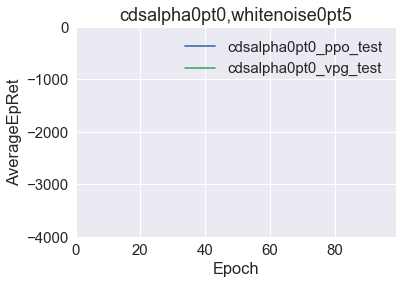

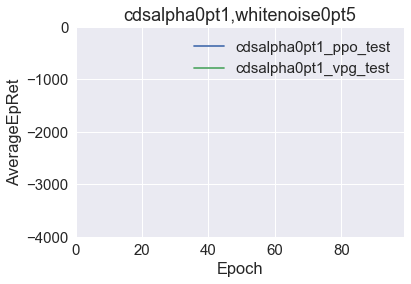

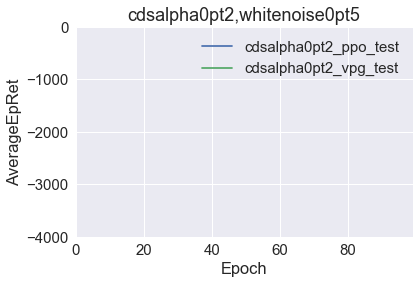

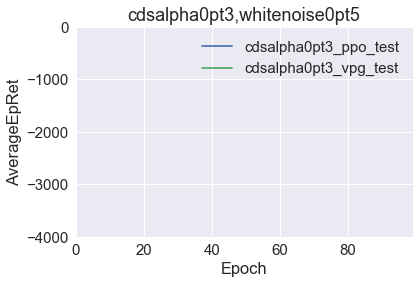

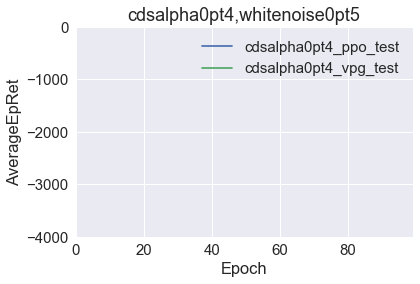

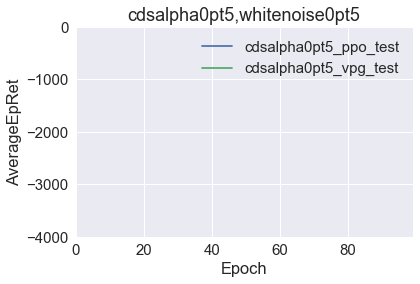

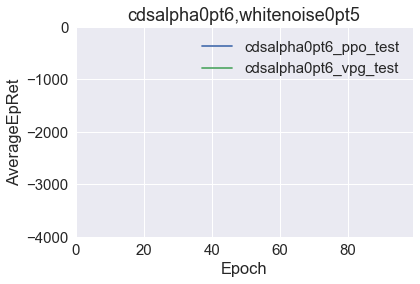

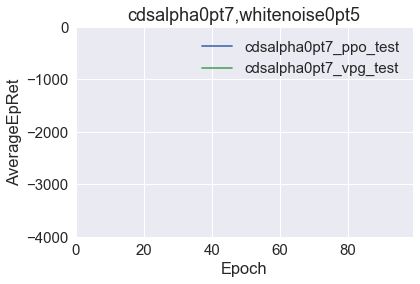

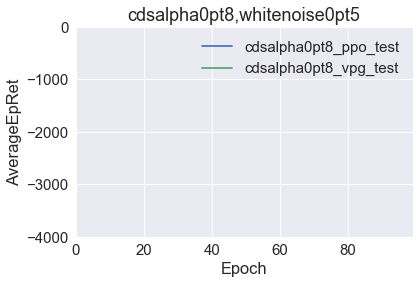

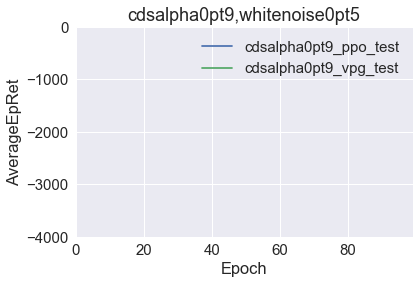

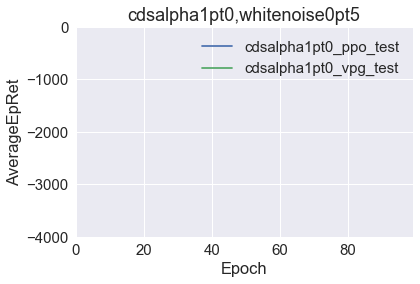

In [18]:
#plot_data(data, xaxis='Epoch', value="AverageEpRet", condition="Condition1", smooth=1, **kwargs)

seed = 1
sigma = 0.5
num_steps_per_epoch=5000
num_epochs = 100 #(this will take like 5-10min per experiment, longer when it performs poorly)

if seed==None:
    seed_str = 'unseeded'
else:
    seed_str = 'seed{0}'.format(seed)

if sigma==0:
    noise_str = 'nonoise'
else:
    noise_str = 'whitenoise{0:.1f}'.format(sigma).replace('.','pt')

# Setup outputs
out_dir = '/Users/nataliebernat/Documents/Github/Research/Doyle_RLandCtrl/RL_outputs'
fig_dir = out_dir+'/figures'
exp_out_dir = '{0}/cdsalpha_tests/{1}/{2}/'.format(out_dir,noise_str,seed_str).replace('.','pt')
exp_fig_dir = '{0}/cdsalpha_tests/{1}/{2}/'.format(fig_dir,noise_str,seed_str).replace('.','pt')

# alphas = [0.4] #[2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0]
for alpha in np.arange(0.0, 1.01, 0.1):#alphas:#
    test_name = 'cdsalpha{0:.1f}'.format(alpha).replace('.','pt')
    data = plot.get_all_datasets([exp_out_dir+test_name], None, None, None)
    plt.figure()
    plt.title('{0},{1}'.format(test_name,noise_str))
    plot.plot_data(data)
    plt.ylim((-4000, 0)) #bottom, top
    plt.savefig(exp_fig_dir+test_name+'_closeup')